# Lab 11 (Evaluable)

We work at the AI department of a hospital. From the digestive area, they are interested to predict the evolution of the Acute Pancreatitis based on the patient data that has been gathered from different stages.
Besides, the digestive area requires a nice User eXperience (UX) webapp that facilitates the new patient's data introduction, data exploration and prediction.

In summary, you as part of the Data Science team should tackle the challenge including:
- An exhaustive analysis of the data of patients introduced in the platform in the past.
- The development of a predictive model to anticipate the evolution of the patient; in particular, to predict if the patient is going to have persistent failure, i.e. "OF_PERSIS_ANYTIME" variable takes value 1.
- The creation of a streamlit app that allows you to view the results of the analysis and interact with the model.
- Adding an explainability tab to the app so that all doctors can understand each prediction for every patient and a global interpretation of the model

# Practice Information:
**Due date:** By end of November, 26th (23:55h)

**Submission procedure:** via Moodle.

**Name:** Silvia Riaño Prado

**NIA:** 241429

In [1]:
import numpy as np
import pandas as pd
import math

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

from sklearn.utils import resample
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor

import pickle

In [2]:
#To see all columns of the datasets
pd.set_option('display.max_columns', None)

To facilitate the process of training and evaluation, we have created a function to split and train the original dataset.

**EX[1]** To evaluate the performance of a binary classification model, which is the appropriate visualization to determine the quality of the performance and the threshold value of the decision?

**Solution:**
By using Shap functions such as "shap_values", in the plot we can easily visualize how the data is divided, determining the distribution among columns of data and decide our own thresholds based on the plot of our data.

# 0) Functions

## 0.1) Training function

In [3]:
def split_and_train(features, stage_df, target, num_var, cat_var, model):
    X = stage_df[features]
    y = stage_df[[target]]


    # Divide the dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_processed=X_train

    print("Number of features after coding:", X_train_processed.shape[1] )

    # Train the model
    model.fit(X_train_processed, y_train)


    # Verify if the model has `feature_importances_`
    if hasattr(model, 'feature_importances_'):
        # Obtain the importance of the features
        importances = model.feature_importances_
        # Create a dataframe with the feature_importance
        num_features = X_train.shape[1]
        feature_indices = np.arange(num_features)
        importance_df = pd.DataFrame({'Feature': feature_indices, 'Importance': importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)


        # Visualize the importance of the features

        plt.figure(figsize=(10, 12))
        plt.barh(X_train.columns[importance_df['Feature']], importance_df['Importance'], color='skyblue')
        plt.xlabel('Importance')
        plt.ylabel('Index of feature')
        plt.title('Importance of the feature')
        plt.gca().invert_yaxis()
        plt.show()
    else:
        print("The model does not have the property of 'feature_importances_'")


    return model, X_test, y_test


**[EX2]** Besides, we have created another function to evaluate the model. Please, complete the function to plot the density charts of the probabilities

## 0.2) Model evaluation function

In [4]:
def evaluation(model, X_test, y_test, target, threshold):

    X_test_processed=X_test
    # Prediction for X_test
    y_test_predict = model.predict(X_test_processed)

    print(confusion_matrix(y_test, y_test_predict))
    print(classification_report(y_test, y_test_predict))

    # Prediction of the probabilities
    y_test_predict_proba = model.predict_proba(X_test_processed)
    y_pred=model.predict(X_test_processed)

    # AUC calculation
    y_test_prob = y_test_predict_proba[:, 1]  # Probabilidades de la clase positiva
    auc = roc_auc_score(y_test, y_test_prob)
    print(f"AUC: {auc:.4f}")

    ##TO DO: Plot of the probabilities distribution

    y_test_total = pd.DataFrame({
        target: y_test.values.flatten(),
        'proba1': y_test_prob
    })

    plt.figure(figsize=(10, 6))
    sns.kdeplot(y_test_total[y_test_total[target] == 0]['proba1'], label='Class 0', fill=True, color='red', alpha=0.5)
    sns.kdeplot(y_test_total[y_test_total[target] == 1]['proba1'], label='Class 1', fill=True, color='blue', alpha=0.5)
    plt.axvline(x=threshold, color='black', linestyle='--', label=f'Threshold: {threshold}')
    plt.title('Density Plot of Predicted Probabilities')
    plt.xlabel('Predicted Probability of Positive Class')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    ##

    # To adjust the prediction according to the threshold value
    y_test_total['Predict'] = (y_test_total['proba1'] >= threshold).astype(int)

    print(confusion_matrix(y_test_total[target], y_test_total["Predict"]))
    print(classification_report(y_test_total[target], y_test_total["Predict"]))

    return y_pred

# 1) Data gathering

We upload the dataset from the last dataset

In [5]:
# Import dataframe
stage2_df = pd.read_csv('Stage_2.csv', sep=";")
stage2_df.head(3)

,ID_PATIENT,BMI,AGE,ALCOHOL_UNITS_WEEK,ALCOHOLCOM,ALCOHOLYEA,YEARABSTIN,ASA,BACTERIALI,COLICBEFOR,HTA,CARDIO,DIABETESAP,DIABETESNE,DYSLIPID,RESP_PREVIOUSDISEA,RENALCRONI,FAMILIARCA,FAMILIAR_A,GENEALTERA,HISTORY_CHOLECYSTECTOMY,HEREDPANCR,NUMBERPREV,PREVIOUS_A,PARASITINF,PCRONICAETIOLOGY,PACKYEAR,CIGARRETEP,SMOKINGYEA,STONESHIST,TRYGLICERI,VIRUSTYPE,ETIOLOGYFI,IPMN_global,OF_PERSIS_ANYTIME,ANTIARRITMICO,ANTIINFLAMATORIO,BETABLOQUEANTES,DIURETICO,IECA,ANTICOAGULANTE,ANTIPLAQUETARIO,ANTIDIABETICO,ESTATINA,BRONCODILATADORES,ANTIDEPRESIVOS,HOURSADMISSPAIN,APCRITER_A,GLASGOWMENTAL,TEMPEAPACHE_ADMISS,PAM_ADMISS,HEARTRATED_ADMISS,RESPFREQUE_ADMISS,SATO2%/FIO2%_ADMISS,SEX
0,1,25.950000,72,0.0,0.0,0,0.0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.00,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,6,1,13,37.0,60.000000,108,18,3.000000,1
1,2,18.769513,87,0.0,0.0,0,0.0,3,0,1,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.00,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,48,1,15,36.7,103.666667,64,16,4.619048,0
2,3,25.280000,55,0.0,0.0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.0,0.75,20,0,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,1,48,1,15,36.0,92.333333,80,16,4.760000,0


# 2) Data wrangling

## 2.1) Feature classification

In [6]:
#Columns selection
columns_to_remove_stage2=["ID_PATIENT", "OF_PERSIS_ANYTIME"]
stage_2_columns=stage2_df.columns
stage_2_columns=[col for col in stage_2_columns if col not in columns_to_remove_stage2]

# numerical & categorical for stage0:
num_variables_stage2 = stage2_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_variables_stage2 = [var for var in num_variables_stage2 if var not in columns_to_remove_stage2]

categorical_variables_stage2 = stage2_df.select_dtypes(include='object').columns.tolist()
categorical_variables_stage2 = [var for var in categorical_variables_stage2 if var not in columns_to_remove_stage2]


## 2.2) Exploratory data analysis

In [7]:
num_variables_stage2.append("OF_PERSIS_ANYTIME")

**[EX3]** Calculate the correlation matrix and plot it of the numerical columns. Which are the top 3 variables with more correlation with "OF_PERSIS_ANYTIME" variable?

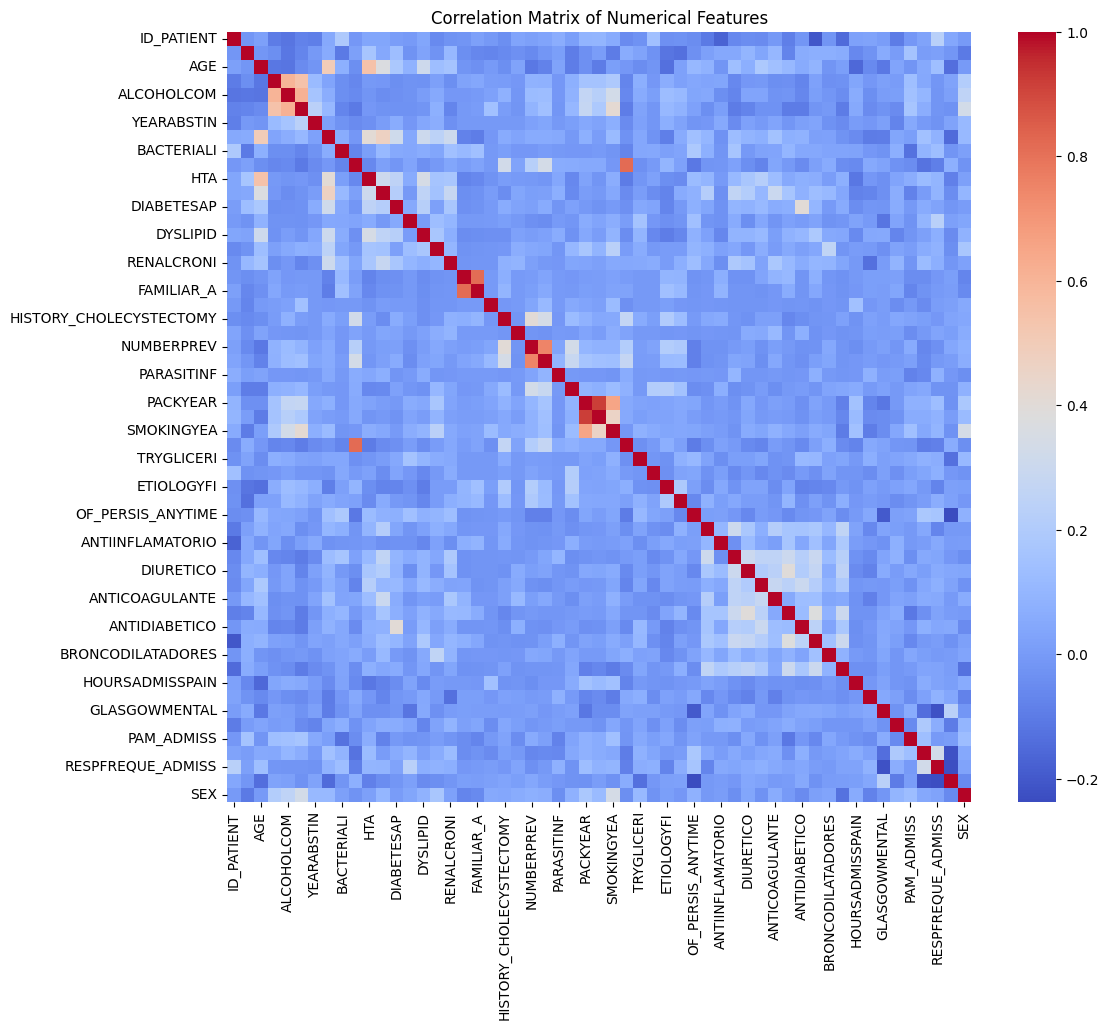

In [8]:
##Solution

#numerical columns only
numerical_columns = stage2_df.select_dtypes(include=['float64', 'int64']).columns

correlation_matrix = stage2_df[numerical_columns].corr()

target_corr = correlation_matrix["OF_PERSIS_ANYTIME"].drop("OF_PERSIS_ANYTIME")  # Exclude self-correlation

#plot correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [9]:
#Solution top 3 correlated
top_3_corr = target_corr.abs().sort_values(ascending=False).head(3)
top_3_corr

SATO2%/FIO2%_ADMISS    0.237365
GLASGOWMENTAL          0.198291
BACTERIALI             0.183964
Name: OF_PERSIS_ANYTIME, dtype: float64

**Solution** The variables that correlates more with OF_PERSIS_ANYTIME are:
SATO2%/FIO2%_ADMISS	with 0.237365
GLASGOWMENTAL	with 0.198291
BACTERIALI	with 0.183964


# 3) Modelling

Let's train our model using the defined functions.

In [10]:
num_variables_stage2 = [var for var in num_variables_stage2 if var not in columns_to_remove_stage2]

In [11]:
model_stage2_OFPA=RandomForestClassifier(n_estimators=107, random_state=42, class_weight="balanced", min_samples_leaf=17, max_depth=19)

Number of features after coding: 53


/workspaces/final_lab11/venv/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


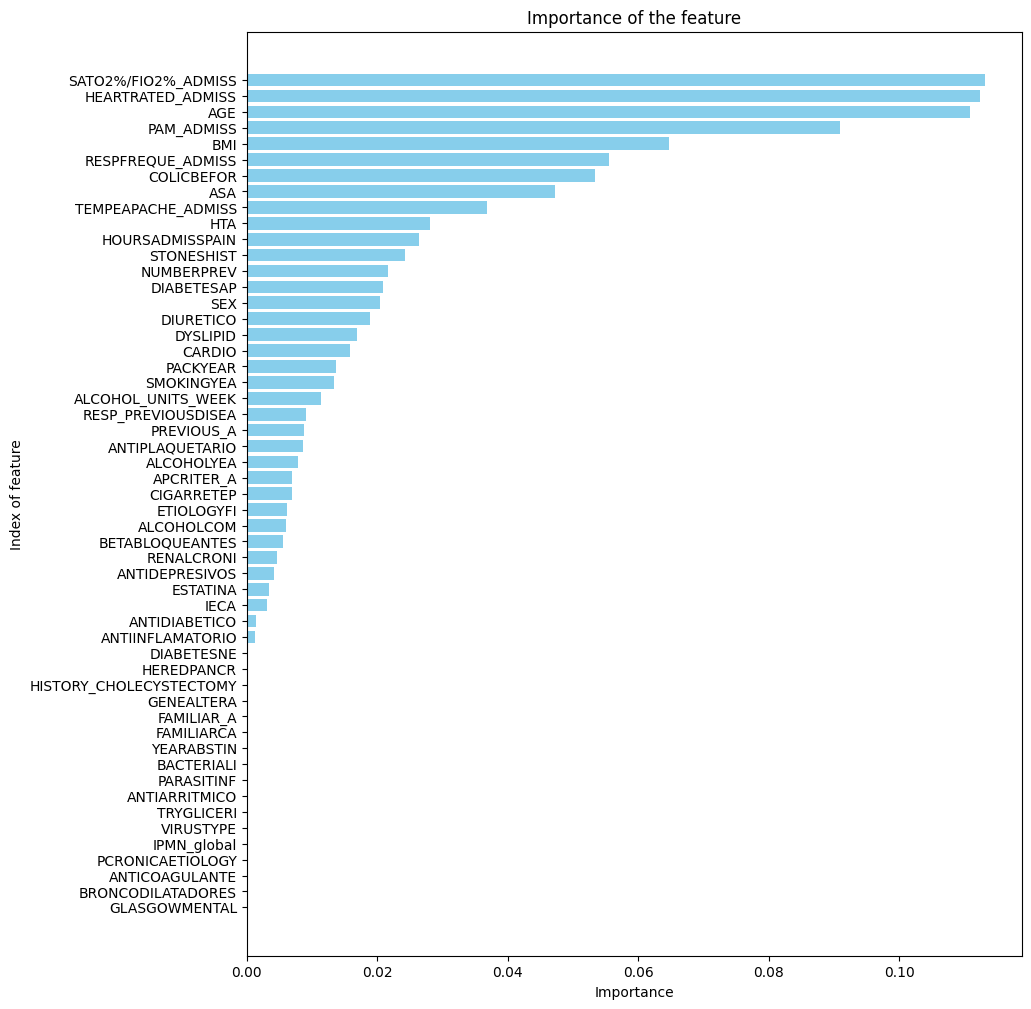

In [12]:
#Training the model
model_trained_OFPA, X_test, y_test=split_and_train (stage_2_columns, stage2_df, "OF_PERSIS_ANYTIME", num_variables_stage2, categorical_variables_stage2, model_stage2_OFPA)

**EX[4]** Evaluate the model using the defined ***evaluation()*** function. In our use case, should we optimize the recall or the precision? Justify your answer.

[[88 11]
 [13  8]]
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        99
           1       0.42      0.38      0.40        21

    accuracy                           0.80       120
   macro avg       0.65      0.63      0.64       120
weighted avg       0.79      0.80      0.80       120



AUC: 0.7754


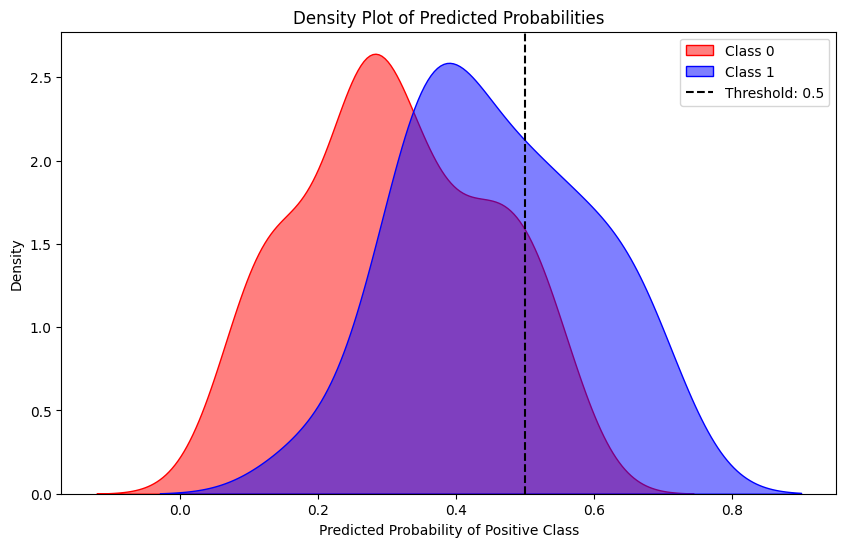

[[88 11]
 [13  8]]
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        99
           1       0.42      0.38      0.40        21

    accuracy                           0.80       120
   macro avg       0.65      0.63      0.64       120
weighted avg       0.79      0.80      0.80       120



array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0])

In [13]:
#Evaluate the model
y_pred = evaluation(model_trained_OFPA, X_test, y_test, target="OF_PERSIS_ANYTIME", threshold=0.5)
y_pred

**Solution:**
It better to optimize recall, in healthcare position is allways better to have a false positive than a false negative.

# 4) Explainability AI

As an excellent data scientist, we cannot conclude our work without understanding how the model works. In this section of the project, we will apply SHAP as a technique to understand, debug and explain our model.

In [14]:
X_test["target"]=y_test
X_test["prediction"]=y_pred
X_test=X_test.reset_index(drop=True)

## 4.1) Global explainability

Train a Shap explainer and calculate the shap_values object for the X_test dataset

In [15]:
import shap
shap.initjs()
explainer=shap.Explainer(model_stage2_OFPA)
shap_values_OFPA = explainer(X_test.iloc[:,:-2])

/workspaces/final_lab11/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**[EX5]** Which is the shspe of shap_values_OFPA object?

In [16]:
##Solution
shap_values_OFPA.shape #120 number of samples, 53 number of features and 2 number of classes

(120, 53, 2)

To access the SHAP values of the class 1 we should use:

In [17]:
# Access to the SHAP values for class 1
shap_values_OFPA_class_1 = shap_values_OFPA[:, :, 1]

**[EX6]** Which is the average prediction for all patients?

In [18]:
#Solution
shap_values_OFPA.base_values #for class 1 is 0.50597409 and class 2 is 0.49402591

array([[0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.50597409, 0.49402591],
       [0.

**[EX7]** Plot the summary plot for global explainability of the model. Which are your insights?

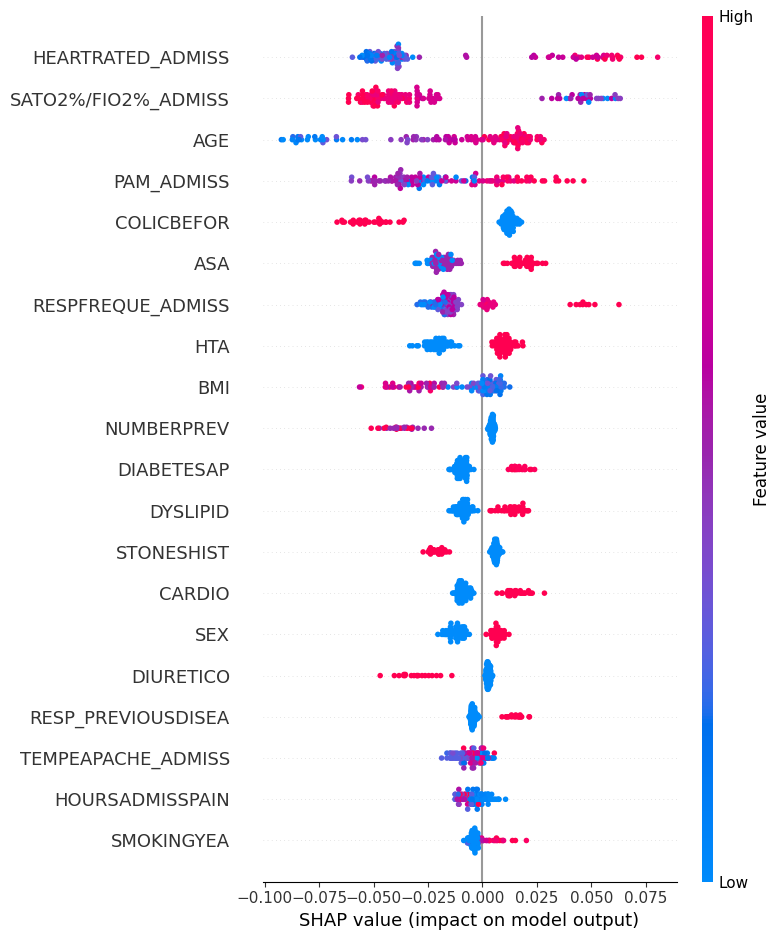

In [19]:
#solution
shap.summary_plot(shap_values_OFPA.values[:,:,1], X_test[num_variables_stage2])

The values that make the probability closer to 1 are those that are more distributed along the axis, such as HEARTRATED ADMISS, SATO2%/FI02% ADMISS, AGE, and PAM ADMISS. These features have been identified as critical drivers of the model's predictions, and analyzing their SHAP values reveals valuable insights into the classification process.
Higher Heart Rate shows that have higher risk, same as age and pam admiss. Where as the SATO2%/FIO2% the lower amount the highest risk.

**EX[8]** Build the bar plot for the global explainability of the model but just for the top 15 variables. Tip: use the max_display=15 in the corresponding plot

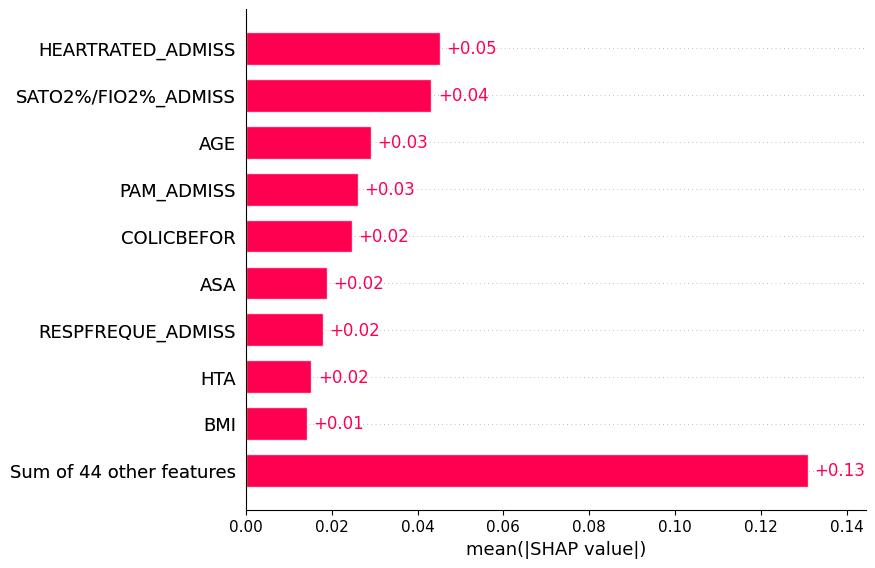

In [20]:
#Solution
#Plot var: built for class 1 of all top 15 shap_values
shap.plots.bar(shap_values_OFPA[:,:,1])

**EX[9]** Let's do deep dive in the variables `AGE`, `HEARTRATED_ADMISS` and `SATO2%/FIO2%_ADMISS`. What are the most relevant insights abour these evolution of the features' values and their Shap values.

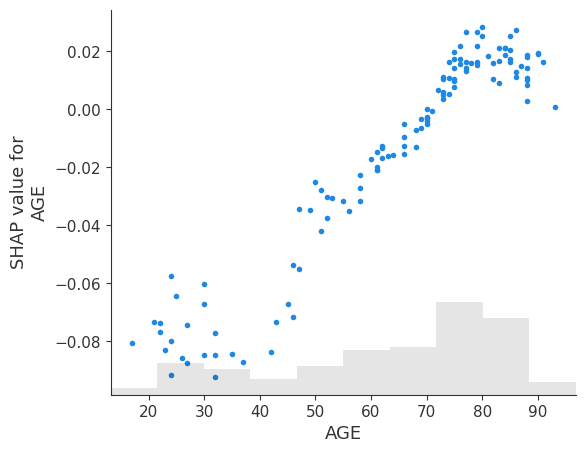

In [21]:
#Solution
shap.plots.scatter(shap_values_OFPA_class_1[:,"AGE"])

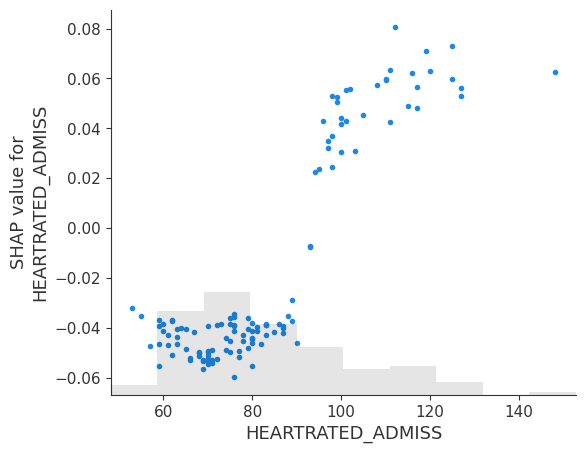

In [22]:
#Solution
shap.plots.scatter(shap_values_OFPA_class_1[:,"HEARTRATED_ADMISS"])

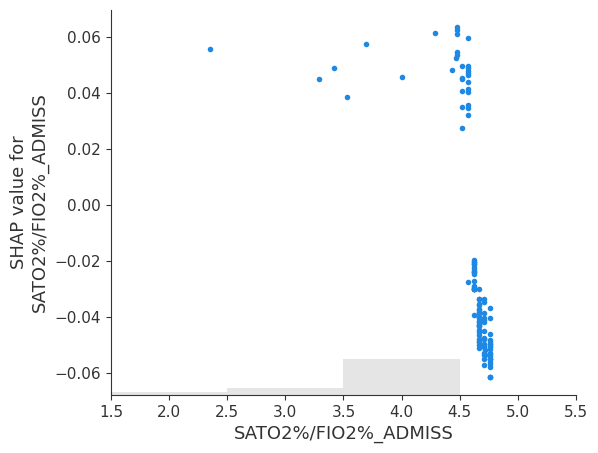

In [23]:
#Solution
shap.plots.scatter(shap_values_OFPA_class_1[:,"SATO2%/FIO2%_ADMISS"])

### Local explainability

Local explainability facilitates the understanding of the prediction for some particular cases. In other words, XAI closes to a personalized prediction explainability. Let's use the first sample of X_test for the following exercises.

**EX[10]** Plot the waterfall and decision plot for two patients: one with prediction of being class 0 (i.e. No OF_PERSIST_ANYTIME) and another with prediction of being class 1 (i.e. OF_PERSIST_ANYTIME)

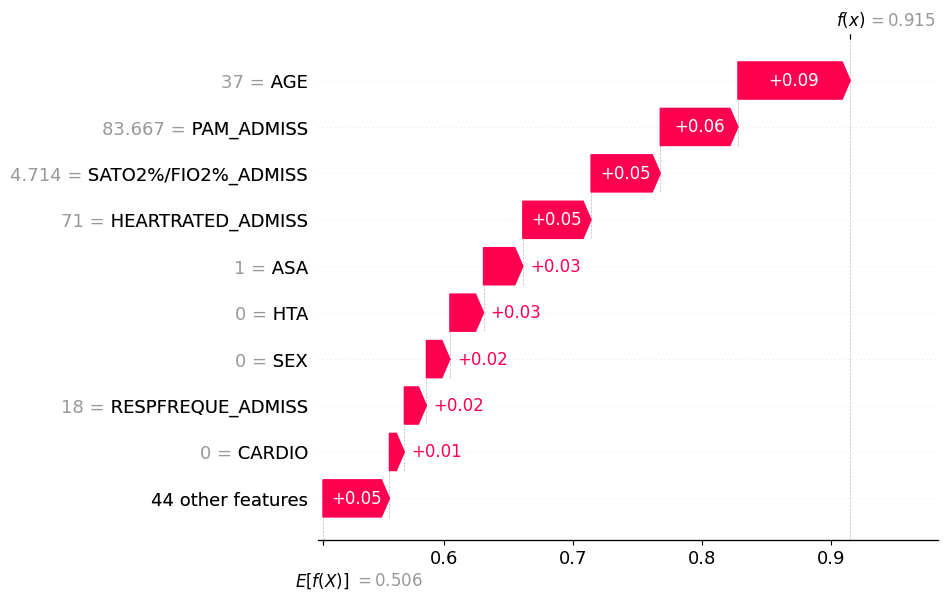

In [24]:
#Solution for a patient with prediction of being class 0
y_pred_proba = model_stage2_OFPA.predict_proba(X_test[num_variables_stage2])

patient_class_0_idx = np.where(y_pred_proba[:, 0] > 0.5)[0][0]
shap_values_class_0 = shap_values_OFPA[patient_class_0_idx]

shap.plots.waterfall(shap_values_class_0[ :, 0])

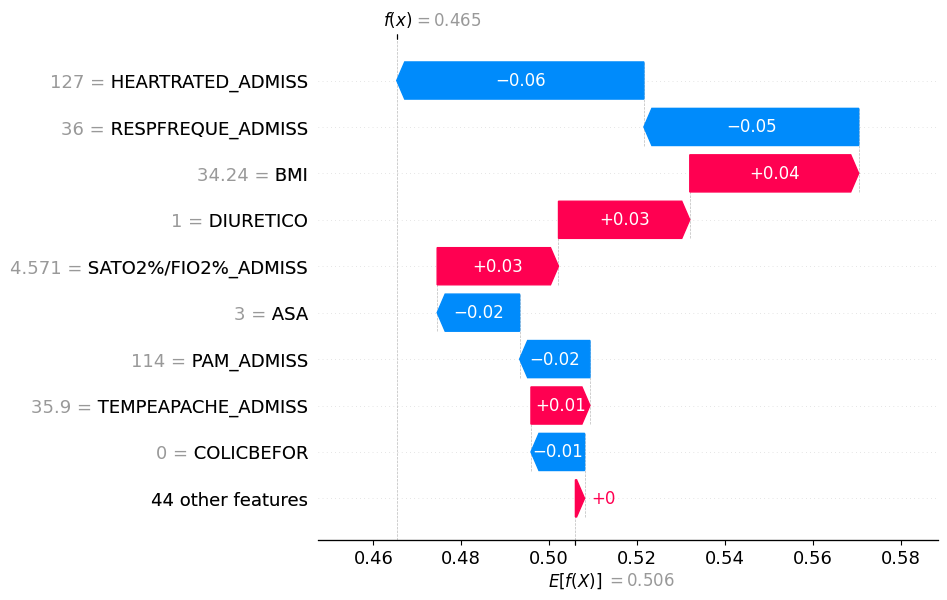

In [25]:
#Solution for a patient with prediction of being class 1
patient_class_1_idx = np.where(y_pred_proba[:, 1] > 0.5)[0][0]
shap_values_class_1 = shap_values_OFPA[patient_class_1_idx]
shap.plots.waterfall(shap_values_class_1[ :, 0])

**EX[11]** Which are the factors that increase the risk of OF_PERSIST_ANYTIME??

**Solution:**
As we can see in the second plot, that refers to the OF_PERSIST_ANTIME risk, the factors that increse the risk are the ones in red that are: BMI, DIURETICO SATO2%/FIO2%_ADMISS TEMPERAPACHE_ADMISS

# 5) Output

As next step you create your own webapp. Store your prediciton model using pickle as follows:

In [26]:
import pickle

# Guardar el modelo en un archivo
filename = 'OF_PERSIS_ANYTIME_classification_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model_trained_OFPA, file)

print(f"Your model has been stored as '{filename}'")

Your model has been stored as 'OF_PERSIS_ANYTIME_classification_model.pkl'
